In [1]:
#Import relevant libraries
import math
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#Read data from CSV file
# data = pd.read_csv('/content/drive/MyDrive/Colab/XAI/insurance.csv')
data = pd.read_csv('insurance.csv')

# Linear Regression

Linear regression is one of the simplest predictive model in machine learning, which predicts the output as a weighted sum of the inputs. The formula for linear regression is:

*y* = w<sub>0</sub> + w<sub>1</sub>x<sub>1</sub> +...w<sub>p</sub>x<sub>p</sub> + ϵ,

where y is the output, w represents the weights, x represents the input features and ϵ is the error between the predictions and the true outcome

## Assumptions of Linear Regression

1. **Linearity:** the output is a linear combination of the inputs
2. **Multivariate normality:** the model's error terms/residuals are normally distributed. When the normality assumption is violated it results in biased p-values and messed up confidence intervals
3. **No multicollinearity:** Ideally, the features/inputs should not be strongly correlated. This is because in the case of two or more strongly correlated features, the effect is additive and so it becomes difficult to figure out which features attribute to the effect and how much.
4. **Homoscedasticity:** This assumes that the "noise" or error term over all the independent features is constant. When this assumption is violated, ordinary least squares (OLS) might be biased towards larger error terms that have more "pull"

In [4]:
#Get information about the columsn
data.info()
data_X = data.drop(columns=['charges', 'sex', 'smoker', 'region'])
data_X['sex'] = [1 if x =='male' else 0 for x in data['sex']] #Dummy encoding for sex: male = 1, female = 0
data_X['smoke'] = [1 if x =='yes' else 0 for x in data['smoker']] #Dummy encoding for whether an individual is a smoker: yes = 1, no = 0
data_region = pd.get_dummies(data['region']) #Get dummy encoding for categorical variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [6]:
#concatenate dummy coded variables with the dataset
data_X = pd.concat([data_X, data_region], axis=1)
#Pick the northeast as a reference and drop that column to avoid the dummy trap
data_X = data_X.drop(columns='northeast')
#Convert X and y to numpy arrays to be ingested by statsmodel
X = np.asarray(data_X, dtype=float)
y = np.asarray(data['charges'], dtype=float)

#Split data into training (66%) and test (33%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
#Fit a linear regression model for X an y in statsmodel
X = sm.add_constant(X_train, prepend=False)
model = sm.OLS(y_train,X)
result = model.fit()
coefs = result.params
error = result.bse
names = list(data_X.columns) + ['intercept']

In [8]:
print(result.summary(xname=names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     325.0
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          1.33e-257
Time:                        11:05:31   Log-Likelihood:                -9081.7
No. Observations:                 896   AIC:                         1.818e+04
Df Residuals:                     887   BIC:                         1.822e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          261.5684     14.590     17.929      0.0

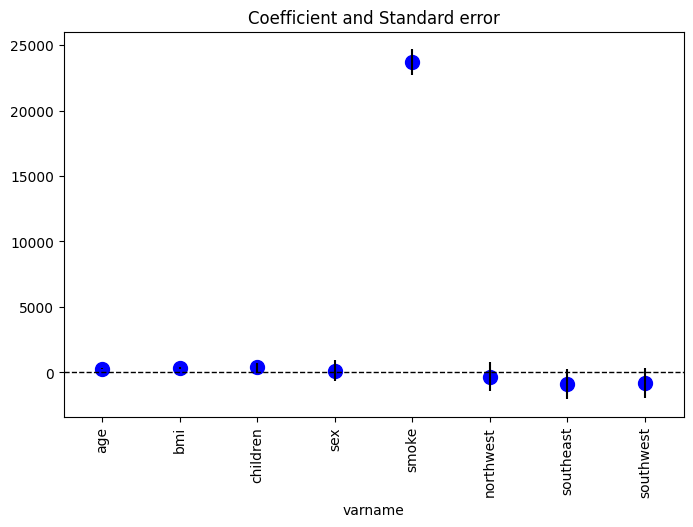

In [9]:
#Plot the weights
err = coefs - result.conf_int()[:,0]
coef_df = pd.DataFrame({'coef': coefs[:-1],
                        'tvalue': result.tvalues[:-1],
                        'err': err[:-1],
                        'varname': names[:-1]
                       })

coef_df.plot(y='coef', x='varname', kind='bar', color='none', yerr='err', legend=False, figsize=(8,5))
plt.scatter(x=np.arange(coef_df.shape[0]), s=100, y=coef_df['coef'], color='blue')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.title("Coefficient and Standard error")
plt.show()

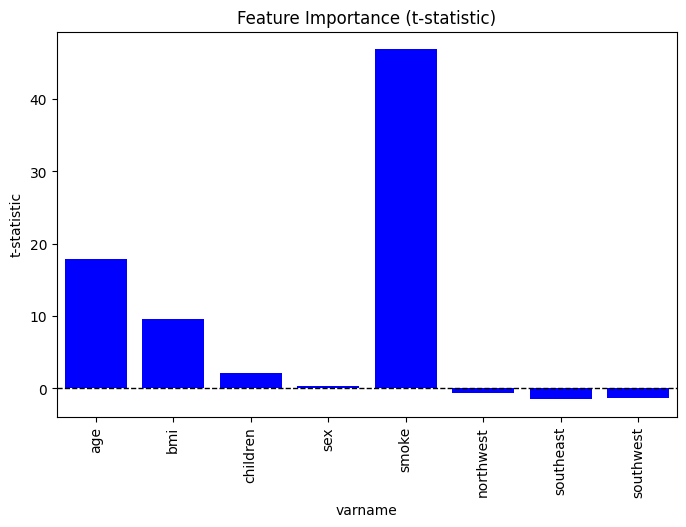

In [10]:
#Plot feature importance
coef_df.plot(y='tvalue', x='varname', kind='bar', color='none', legend=False, figsize=(8,5))
plt.bar(names[:-1], coef_df['tvalue'], color='blue')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.title("Feature Importance (t-statistic)")
plt.ylabel('t-statistic')
plt.show()

Text(0, 0.5, 'Feature Effect')

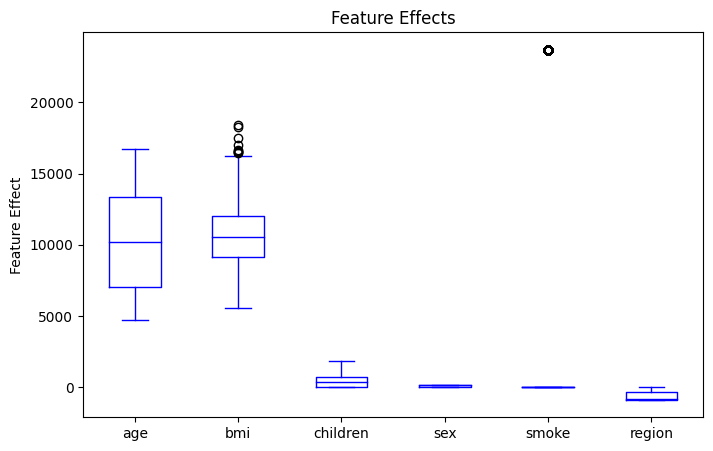

In [11]:
def calculate(to_calc_df):
    return to_calc_df["northwest"] + to_calc_df["southeast"] +  to_calc_df["southwest"]
#Plot Feature effects
effects = coefs[:-1]*data_X #Multiply the weights with the corresponding features
effects = effects.loc[:,~effects.columns.duplicated()]
#effects['region'] = effects['northwest'] + effects['southeast'] + effects['southwest'] #add the effect of all regions
effects["region"] = effects.apply(calculate, axis=1)
effects = effects.drop(columns = ['northwest', 'southwest', 'southeast']) #drop columns to prevent redundancies
effects.boxplot(grid=False, figsize=(8,5), color='blue')
plt.title("Feature Effects")
plt.ylabel('Feature Effect')

Text(0, 0.5, 'Insurance costs (in $)')

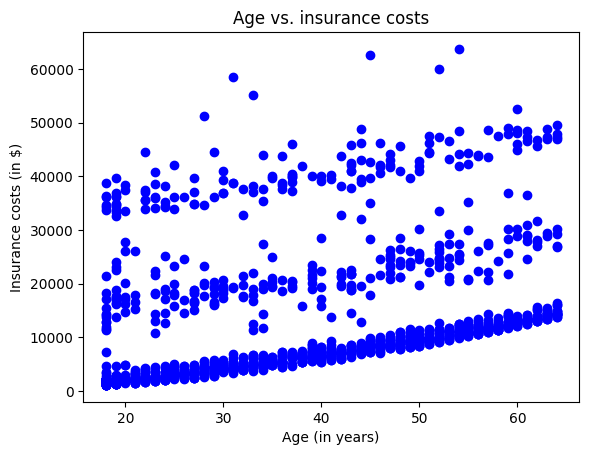

In [12]:
#Plot age vs. insurance
plt.scatter(data_X['age'], y, color='blue')
plt.title('Age vs. insurance costs')
plt.xlabel('Age (in years)')
plt.ylabel('Insurance costs (in $)')

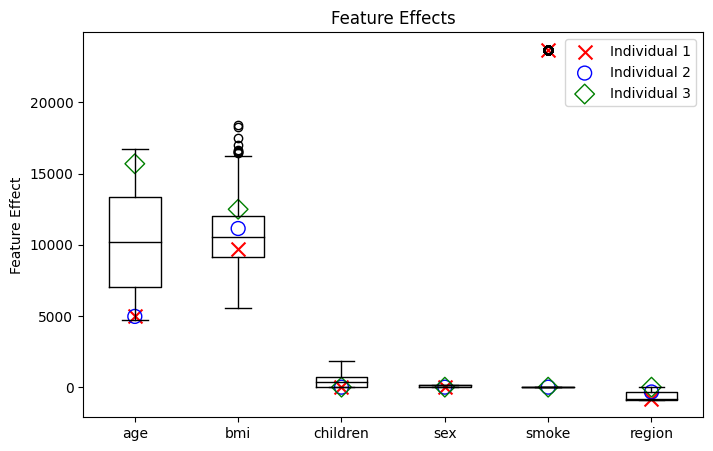

In [13]:
#Plot the effects of 3 individuals
effects = coefs[:-1]*data_X
effects = effects.loc[:,~effects.columns.duplicated()]
effects['region'] = effects['northwest'] + effects['southeast'] + effects['southwest']
effects = effects.drop(columns = ['northwest', 'southwest', 'southeast'])
effects.boxplot(labels=effects.columns, positions=range(len(effects.columns)), grid=False, figsize=(8,5), color='black')
plt.scatter(x=effects.columns, y=effects.iloc[0], color='red', marker='x', s=100, label = 'Individual 1')
plt.scatter(x=effects.columns, y=effects.iloc[200], color='blue', marker='o', facecolors='none',s=100, label = 'Individual 2')
plt.scatter(x=effects.columns, y=effects.iloc[20], color='green', marker='D', facecolors='none',s=100, label = 'Individual 3')
plt.title("Feature Effects")
plt.ylabel('Feature Effect')
plt.legend()

# Prediction and Testing

In [14]:
#Fit regression model
lr = LinearRegression()
model_lr = lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
print("Root mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Root mean squared error: 5923.70
Coefficient of determination: 0.76


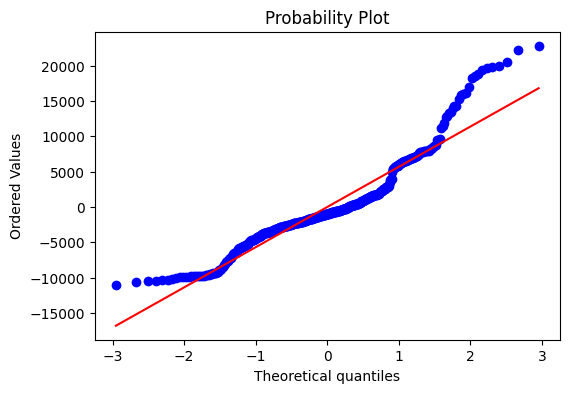

In [16]:
import scipy as sp
#Plot QQplot
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(y_test-y_pred, plot=ax, fit=True)
plt.show()

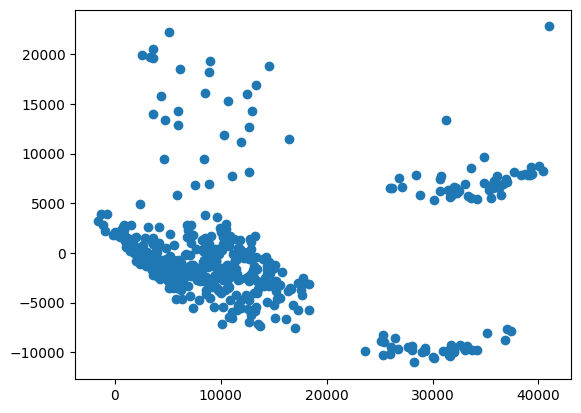

In [17]:
#Plot a scatter plot of the residuals
plt.scatter(y_pred, y_test-y_pred)

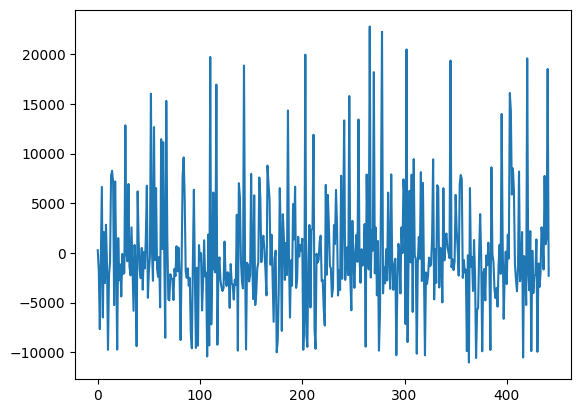

In [18]:
#Plot autocorrelations
plt.plot(y_test-y_pred)

<AxesSubplot:>

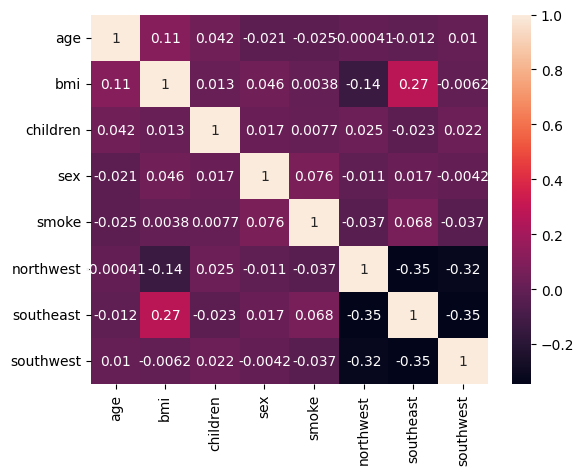

In [19]:
#Plot correlation matrix
sns.heatmap(data_X.corr(), annot=True)